In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to the directory where your dataset is stored in Google Drive
data_dir = '/content/drive/MyDrive/MLSA BUP/Classification'

import pandas as pd

# Load the CSV file
csv_path = f'{data_dir}/image_label.csv'
dataset = pd.read_csv(csv_path)

# Display the first few rows and class distribution
print(dataset.head())
print("Class Distribution:\n", dataset['Plane'].value_counts())


                   Image_name        Plane
0  Patient01018_Plane3_2_of_3  Fetal brain
1  Patient00770_Plane3_2_of_3  Fetal brain
2  Patient00853_Plane3_1_of_3  Fetal brain
3  Patient01230_Plane3_5_of_5  Fetal brain
4  Patient01494_Plane3_3_of_4  Fetal brain
Class Distribution:
 Plane
Fetal brain      556
Fetal thorax     451
Fetal abdomen    339
Fetal femur      300
Name: count, dtype: int64


In [4]:
import os
import cv2
import numpy as np

# Directory where images are stored
image_dir = f'{data_dir}/images'

# Target image size (adjust as needed)
img_size = (256, 256)

# Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(dataset['Plane'].unique())}
dataset['Label'] = dataset['Plane'].map(label_mapping)

# Load images and labels as arrays
def load_data(dataset, image_dir):
    images = []
    labels = []
    for _, row in dataset.iterrows():
        image_path = os.path.join(image_dir, f"{row['Image_name']}.png")
        if os.path.exists(image_path):
            # Load and resize the image
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, img_size)
            images.append(img_resized)
            labels.append(row['Label'])
        else:
            print(f"Image not found: {image_path}")
    return np.array(images), np.array(labels)

# Load the dataset
images, labels = load_data(dataset, image_dir)

# Reshape and normalize the images
images = images[..., np.newaxis] / 255.0  # Add channel dimension and normalize


In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Display the shape of the datasets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (1316, 256, 256, 1)
Validation data shape: (330, 256, 256, 1)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model with increased complexity
def create_model(input_shape=(256, 256, 1), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),  # Additional convolutional layer
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate and compile the model with a reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model = create_model()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,012 (25.98 MB)

 Trainable params: 6,811,012 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from sklearn.utils import class_weight

# Calculate class weights based on label distribution
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(labels), y=labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.7401079136690647, 1: 1.3716666666666666, 2: 0.9124168514412417, 3: 1.2138643067846608}


In [20]:
# Define model checkpoint path
checkpoint_path = '/content/drive/MyDrive/MLSA BUP/best_model.keras'  # Ensure `.keras` extension

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),  # Increased patience
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Learning rate scheduler
]


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

# Define the training generator with augmented data
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Train the model with data augmentation and updated callbacks
history = model.fit(train_generator, epochs=20, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=callbacks)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step - accuracy: 0.3098 - loss: 1.3936 - val_accuracy: 0.4424 - val_loss: 1.2416 - learning_rate: 1.0000e-04
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.4433 - loss: 1.2417 - val_accuracy: 0.5545 - val_loss: 1.0187 - learning_rate: 1.0000e-04
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.5439 - loss: 1.1136 - val_accuracy: 0.7485 - val_loss: 0.8301 - learning_rate: 1.0000e-04
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.5855 - loss: 1.0323 - val_accuracy: 0.7788 - val_loss: 0.7119 - learning_rate: 1.0000e-04
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.6593 - loss: 0.9090 - val_accuracy: 0.7697 - val_loss: 0.6783 - learning_rate: 1.0000e-04
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.6800 - loss: 0.8520 - val_accuracy: 0.8000 - val_loss: 0.6234 - learning_rate: 1.0000e-04
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7235

In [22]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8663 - loss: 0.4507
Validation Accuracy: 88.18%


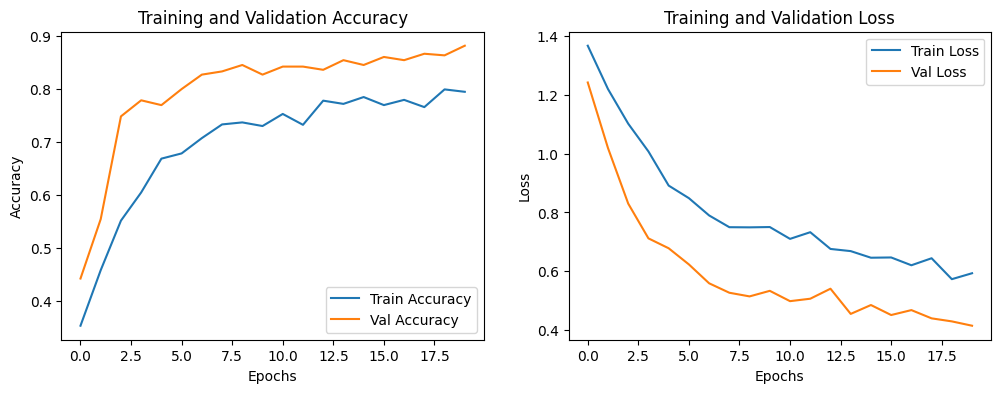

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [24]:
import os
import cv2
import numpy as np

# Define the test images directory
test_image_dir = '/content/drive/MyDrive/MLSA BUP/Classification/External Test images'
img_size = (256, 256)  # Ensure this matches the input size used during training

# Function to load and preprocess test images
def load_test_images(image_dir):
    images = []
    image_names = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, img_size) / 255.0  # Normalize
            img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
            images.append(img_resized)
            image_names.append(img_name)
    return np.array(images), image_names

# Load the test images
X_test, test_image_names = load_test_images(test_image_dir)

print("Loaded test images:", len(X_test))


Loaded test images: 40


In [25]:
# Predict on test images
predictions = model.predict(X_test)

# Decode predictions into class labels
predicted_labels = [list(label_mapping.keys())[np.argmax(pred)] for pred in predictions]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


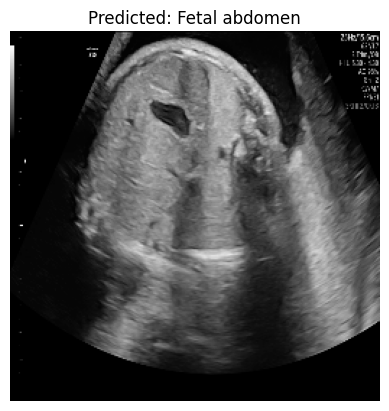

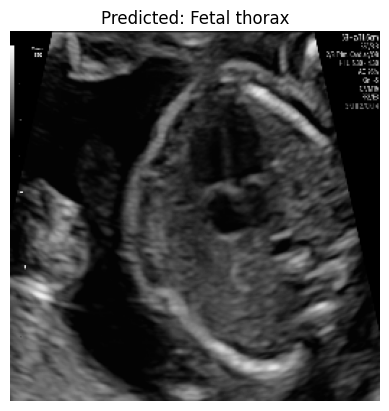

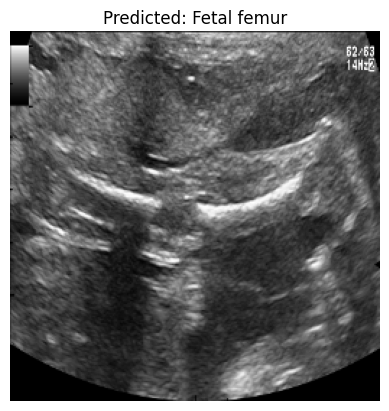

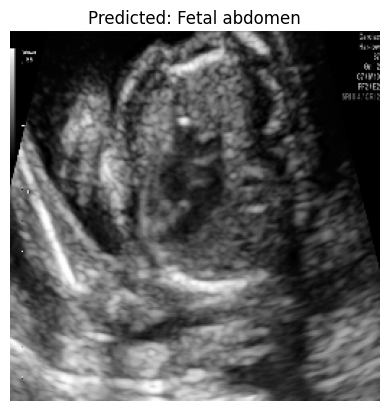

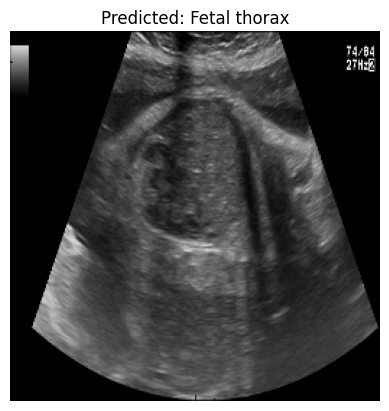

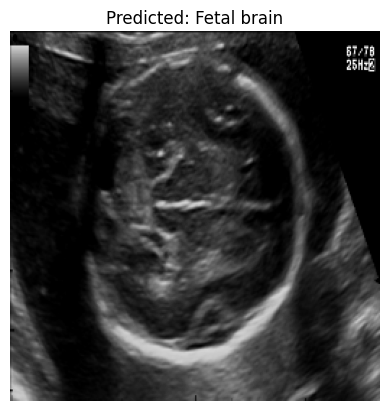

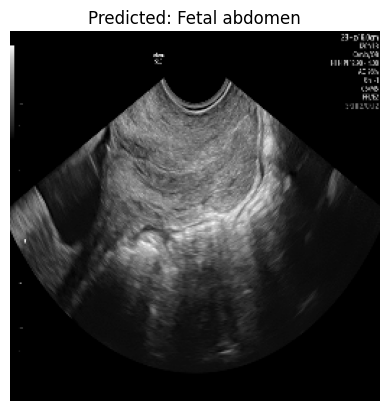

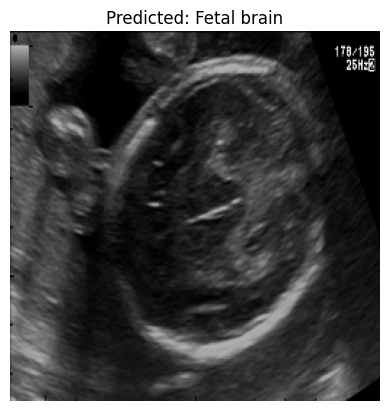

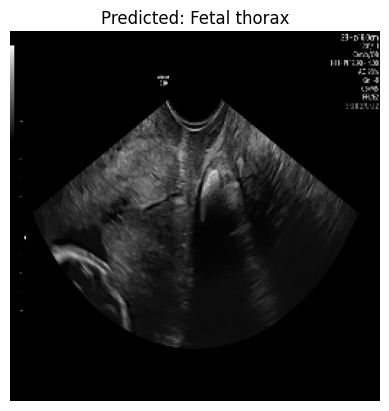

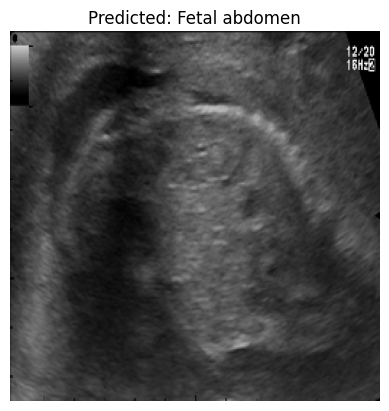

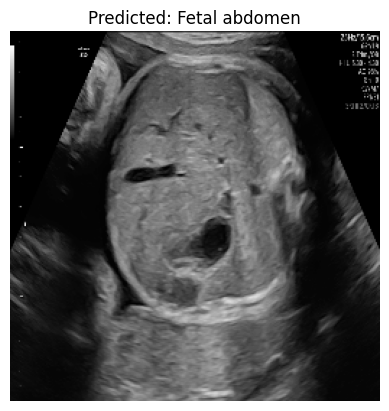

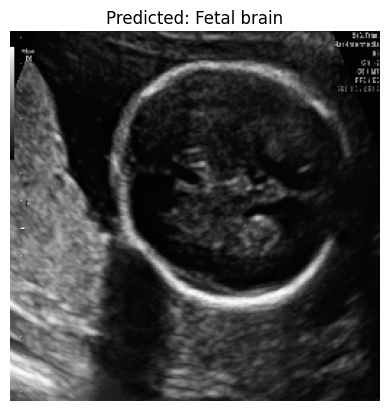

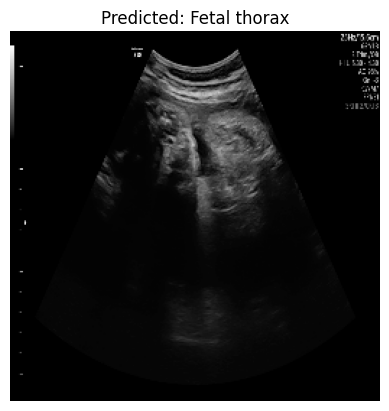

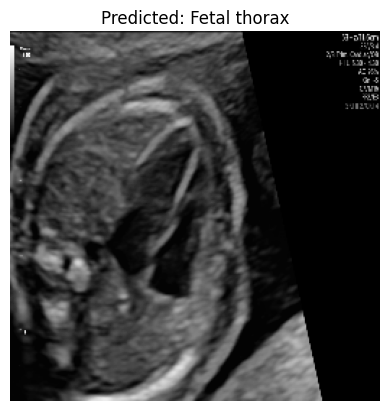

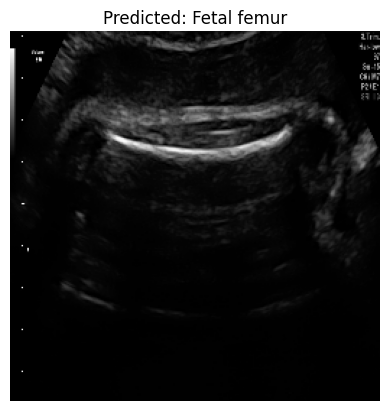

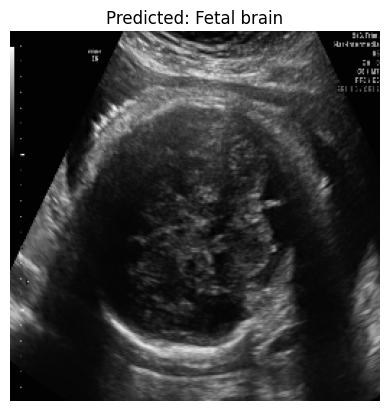

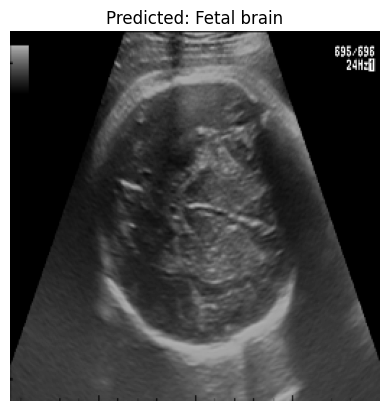

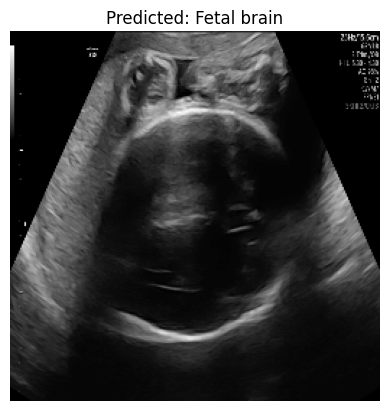

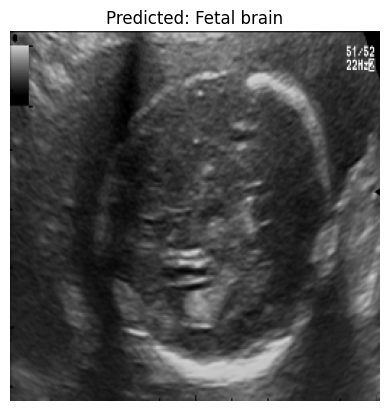

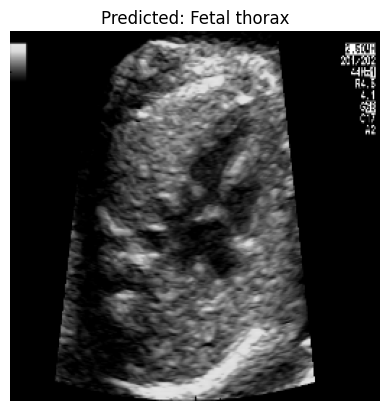

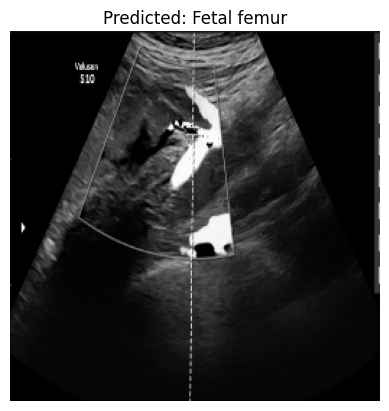

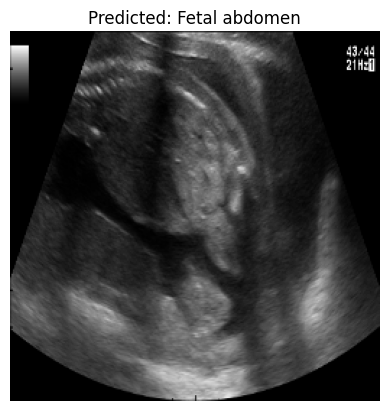

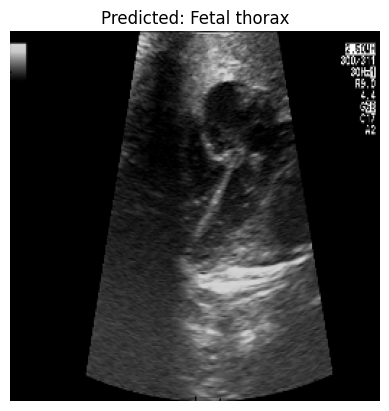

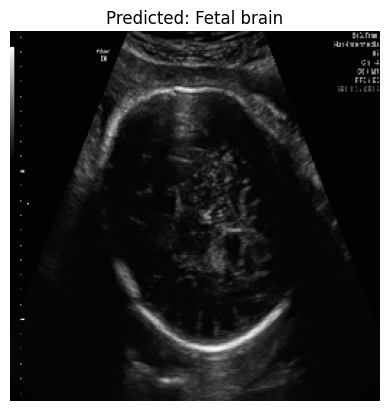

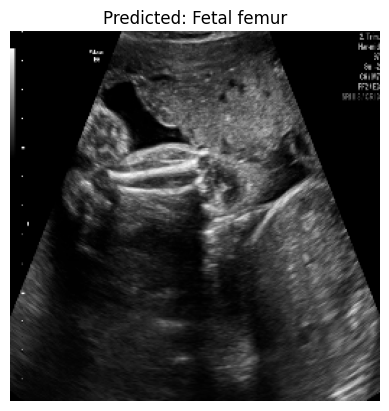

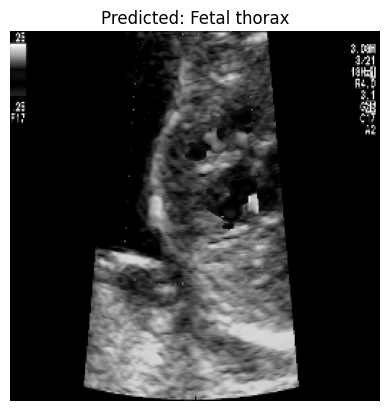

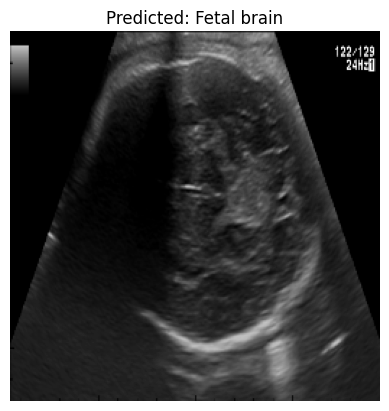

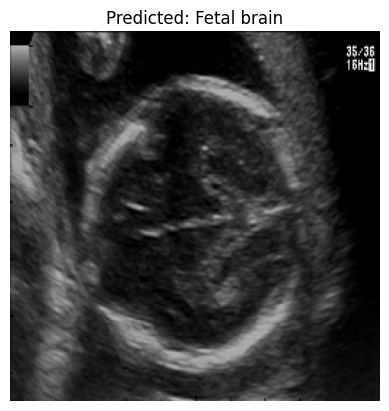

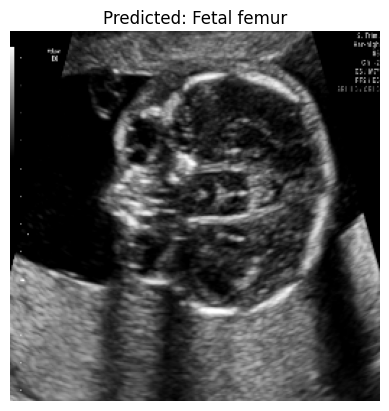

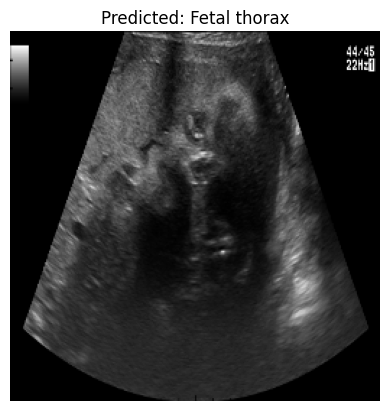

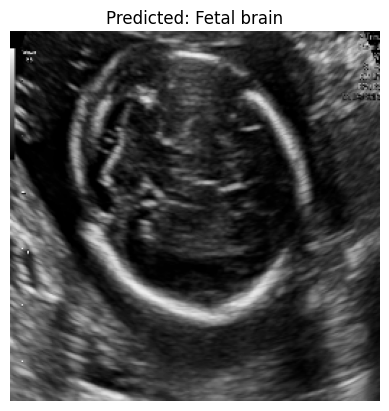

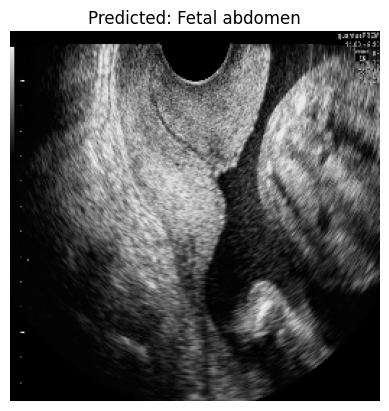

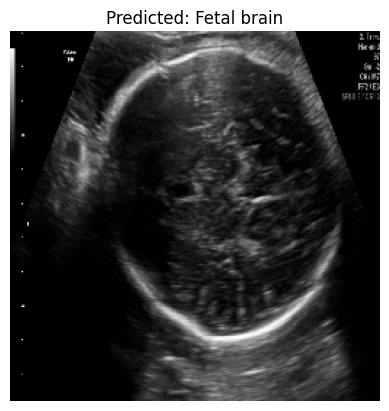

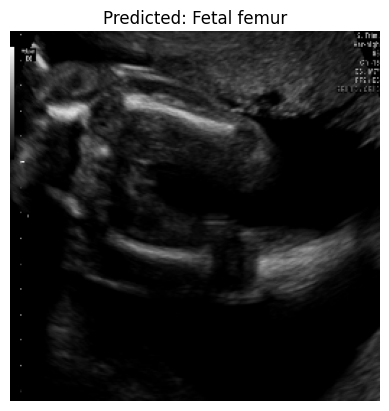

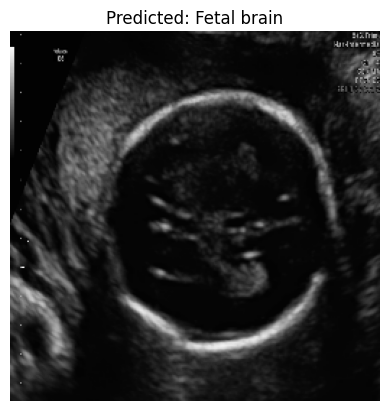

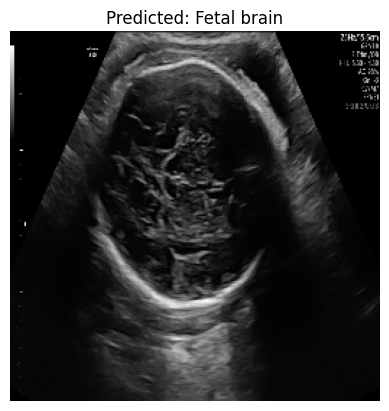

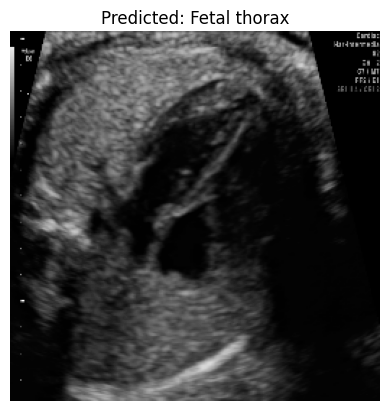

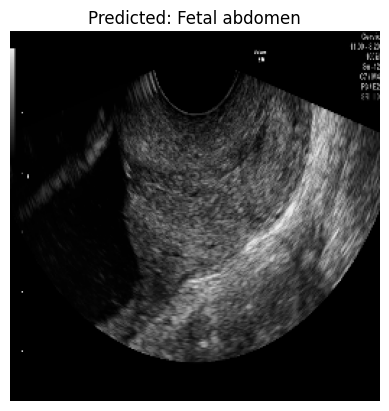

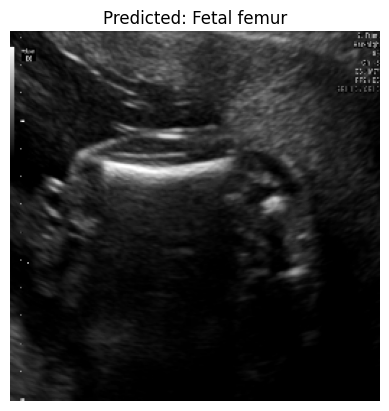

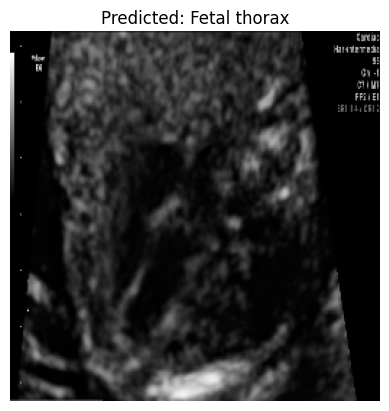

In [26]:
import matplotlib.pyplot as plt

# Display test images with predicted labels
for i in range(len(X_test)):
    plt.imshow(X_test[i].reshape(256, 256), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()


In [29]:
from collections import defaultdict

# Group images by predicted class
grouped_predictions = defaultdict(list)
for i, label in enumerate(predicted_labels):
    grouped_predictions[label].append(test_image_names[i])

# Display the grouped results
for label, images in grouped_predictions.items():
    print(f"\nPredicted Class: {label}")
    print("Images:", images[:10])  # Display only the first 10 image names for brevity



Predicted Class: Fetal abdomen
Images: ['Patient01695_Plane2_1_of_1.png', 'Patient01616_Plane6_1_of_1.png', 'Patient01690_Plane4_1_of_1.png', 'Patient01672_Plane1_10_of_10.png', 'Patient01689_Plane2_1_of_1.png', 'Patient01612_Plane1_19_of_21.png', 'Patient01623_Plane4_2_of_3.png', 'Patient01679_Plane4_3_of_9.png']

Predicted Class: Fetal thorax
Images: ['Patient01698_Plane6_2_of_3.png', 'Patient01630_Plane1_1_of_3.png', 'Patient01693_Plane4_1_of_1.png', 'Patient01676_Plane1_1_of_14.png', 'Patient01692_Plane6_1_of_1.png', 'Patient01696_Plane6_1_of_3.png', 'Patient01715_Plane6_1_of_1.png', 'Patient01631_Plane1_14_of_16.png', 'Patient01657_Plane1_2_of_2.png', 'Patient01660_Plane6_2_of_2.png']

Predicted Class: Fetal femur
Images: ['Patient01672_Plane5_2_of_2.png', 'Patient01650_Plane5_2_of_2.png', 'Patient01676_Plane1_14_of_14.png', 'Patient01678_Plane1_1_of_1.png', 'Patient01635_Plane3_1_of_4.png', 'Patient01707_Plane5_3_of_3.png', 'Patient01706_Plane1_1_of_1.png']

Predicted Class: Fet

In [30]:
# Display predictions with confidence scores
for i, pred in enumerate(predictions):
    confidence = np.max(pred)  # Confidence score of the top prediction
    predicted_label = predicted_labels[i]
    print(f"Image: {test_image_names[i]}, Predicted: {predicted_label}, Confidence: {confidence:.2f}")


Image: Patient01695_Plane2_1_of_1.png, Predicted: Fetal abdomen, Confidence: 0.81
Image: Patient01698_Plane6_2_of_3.png, Predicted: Fetal thorax, Confidence: 0.50
Image: Patient01672_Plane5_2_of_2.png, Predicted: Fetal femur, Confidence: 0.99
Image: Patient01616_Plane6_1_of_1.png, Predicted: Fetal abdomen, Confidence: 0.45
Image: Patient01630_Plane1_1_of_3.png, Predicted: Fetal thorax, Confidence: 0.53
Image: Patient01697_Plane3_1_of_2.png, Predicted: Fetal brain, Confidence: 0.96
Image: Patient01690_Plane4_1_of_1.png, Predicted: Fetal abdomen, Confidence: 0.93
Image: Patient01671_Plane3_1_of_3.png, Predicted: Fetal brain, Confidence: 0.90
Image: Patient01693_Plane4_1_of_1.png, Predicted: Fetal thorax, Confidence: 0.67
Image: Patient01672_Plane1_10_of_10.png, Predicted: Fetal abdomen, Confidence: 0.80
Image: Patient01689_Plane2_1_of_1.png, Predicted: Fetal abdomen, Confidence: 0.92
Image: Patient01702_Plane3_4_of_8.png, Predicted: Fetal brain, Confidence: 0.98
Image: Patient01676_Plane